In [2]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

import torch
from transformers import AutoModelForImageClassification, AutoImageProcessor

from captum.attr import IntegratedGradients

# Helper functions
import sys
sys.path.append('../')

from utils.visualise import process_attributions

In [2]:
import sys
sys.path.append('../')

from utils.download import save_image

# Download example image
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/A_front_view_of_the_face_of_the_boxer_dog_breed.jpg/330px-A_front_view_of_the_face_of_the_boxer_dog_breed.jpg"
save_image(url, "dog.png")

## Load model

In [2]:
# Load model and processor
model_name = "hilmansw/resnet18-catdog-classifier"
base_model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)
base_model.eval()

# Wrap model to return only logits
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        outputs = self.model(x)
        return outputs.logits  # Captum needs a Tensor output

model = WrappedModel(base_model)
model.zero_grad()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:30: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


In [ ]:
# Load and preprocess images
dog_img = Image.open("dog.png") #Update path
dog_inputs = processor(images=dog_img, return_tensors="pt")

print(dog_inputs['pixel_values'].shape)  # Should be [1, 3, 224, 224]

torch.Size([1, 3, 224, 224])


Figure saved to /Users/conorosullivan/Documents/XAI/ig_input.pdf


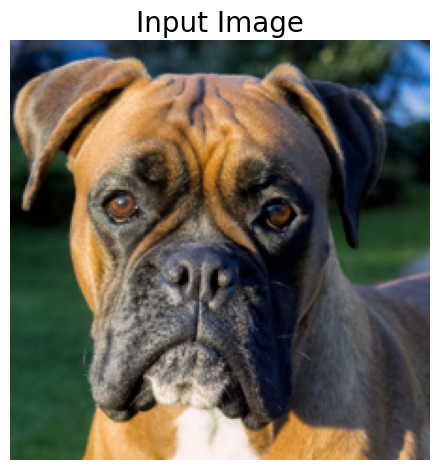

In [3]:
# Load a sample image
img_path = "dog.png"
img = Image.open(img_path).convert("RGB")

plt.imshow(img)
plt.title("Input Image")
plt.axis('off')

In [4]:
# Forward pass
with torch.no_grad():
    logits = model(dog_inputs["pixel_values"])
    predicted_class_idx = logits.argmax(-1).item()

    print("Logits:", logits)
    print(f"Class idx: {predicted_class_idx}")
    print(f"Class:", base_model.config.id2label[predicted_class_idx])

Logits: tensor([[-5.7066,  8.0213]])
Class idx: 1
Class: dogs


### Integrated Gradients

In [5]:
# Initialize Integrated Gradients
model.zero_grad()
ig = IntegratedGradients(model)

In [6]:
# Zero baseline
zero_baseline = np.zeros_like(dog_img)
zero_baseline_tensor = processor(images=zero_baseline, return_tensors="pt",crop_pct=1.0)

# Compute attributions
attributions = ig.attribute(
    inputs=dog_inputs["pixel_values"],
    baselines=zero_baseline_tensor["pixel_values"],
    target=1
)

Figure saved to /Users/conorosullivan/Documents/XAI/ig_default_steps.pdf


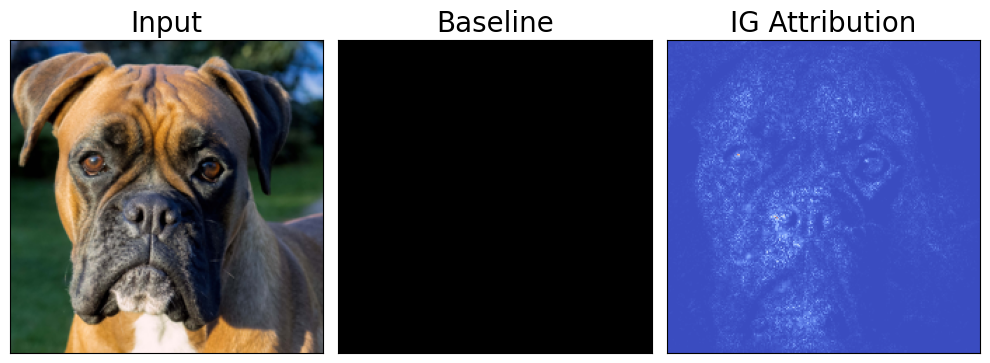

In [7]:
# Visualize attributions
attr = process_attributions(attributions,
                    activation="abs",
                    colormap='coolwarm')

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

# Input
ax[0].imshow(dog_img)
ax[0].set_title("Input",size=20)

#Baseline
ax[1].imshow(zero_baseline)
ax[1].set_title("Baseline",size=20)

# attribution
ax[2].imshow(attr,vmin=0,vmax=1)
ax[2].set_title("IG Attribution",size=20)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

### Vary step number

In [8]:
## Vary step number
attributions = ig.attribute(
    inputs=dog_inputs["pixel_values"],
    baselines=zero_baseline_tensor["pixel_values"],
    n_steps=10,
    target=1,
)

In [9]:
attr_list = []
steps = [1,2,5,10,20,50]
for n in steps:

    # Reset gradients
    model.zero_grad()

    inputs = dog_inputs["pixel_values"].clone().requires_grad_(True)
    if inputs.grad is not None:
        inputs.grad.zero_()

    # Calculate attributions
    attributions = ig.attribute(
        inputs=inputs,
        baselines=zero_baseline_tensor["pixel_values"],
        n_steps=n,
        target=1,
    )

    # Process attributions
    attr = process_attributions(attributions,
                    activation="abs",
                    colormap='coolwarm')
    attr_list.append(attr)

Figure saved to /Users/conorosullivan/Documents/XAI/ig_vary_steps.pdf


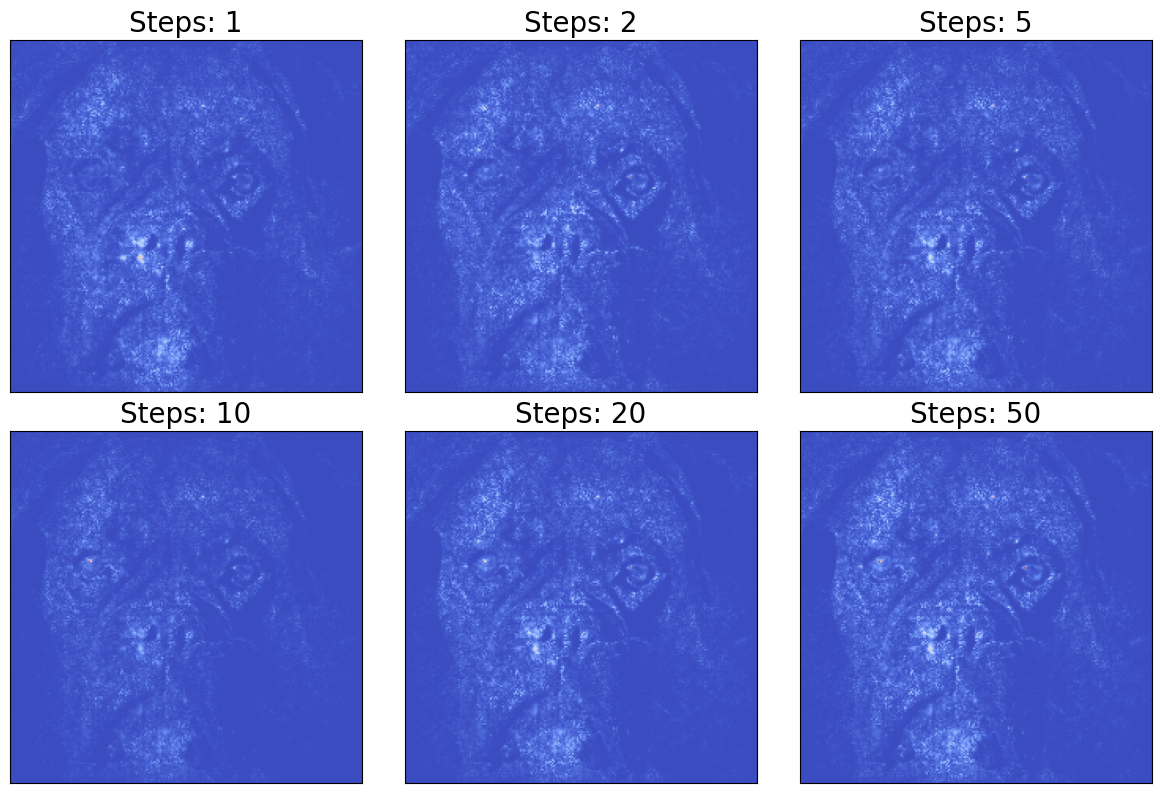

In [11]:
fig,ax = plt.subplots(2, 3, figsize=(12, 8))

ax_flat = ax.flatten()
for i,attr in enumerate(attr_list):

    ax_flat[i].imshow(attr, cmap = 'coolwarm',vmin=0,vmax=1)
    ax_flat[i].set_title(f'Steps: {steps[i]}')

    ax_flat[i].set_xticks([])
    ax_flat[i].set_yticks([])

### Comparision to DeepLIFT

In [15]:
from captum.attr import DeepLift

# Initialize DeepLift
model.zero_grad()
deeplift = DeepLift(model)

inputs = dog_inputs["pixel_values"].clone().requires_grad_(True)
if inputs.grad is not None:
    print("Resetting gradients")
    inputs.grad.zero_()

# Compute attributions (cat vs zero)
attributions = deeplift.attribute(
    inputs=dog_inputs["pixel_values"],
    baselines=zero_baseline_tensor["pixel_values"],
    target=1
)

attr = process_attributions(attributions,
                    activation="abs",
                    colormap='coolwarm')

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


Figure saved to /Users/conorosullivan/Documents/XAI/ig_vs_deeplift.pdf


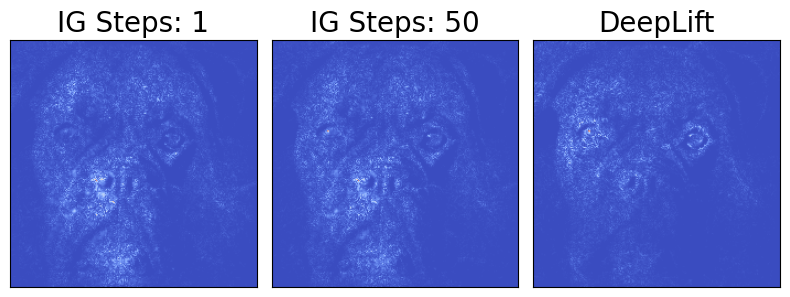

In [16]:
fig,ax = plt.subplots(1, 3, figsize=(8, 4))

ax[0].imshow(attr_list[0],cmap='coolwarm',vmin=0,vmax=1)
ax[0].set_title(f'IG Steps: {steps[0]}')
ax[1].imshow(attr_list[-1],cmap='coolwarm',vmin=0,vmax=1)
ax[1].set_title(f'IG Steps: {steps[-1]}')
ax[2].imshow(attr,cmap='coolwarm',vmin=0,vmax=1)
ax[2].set_title('DeepLift')

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])